<h1 style='color:Red', align = 'center' >Handwritten Digit Recognization</h1>

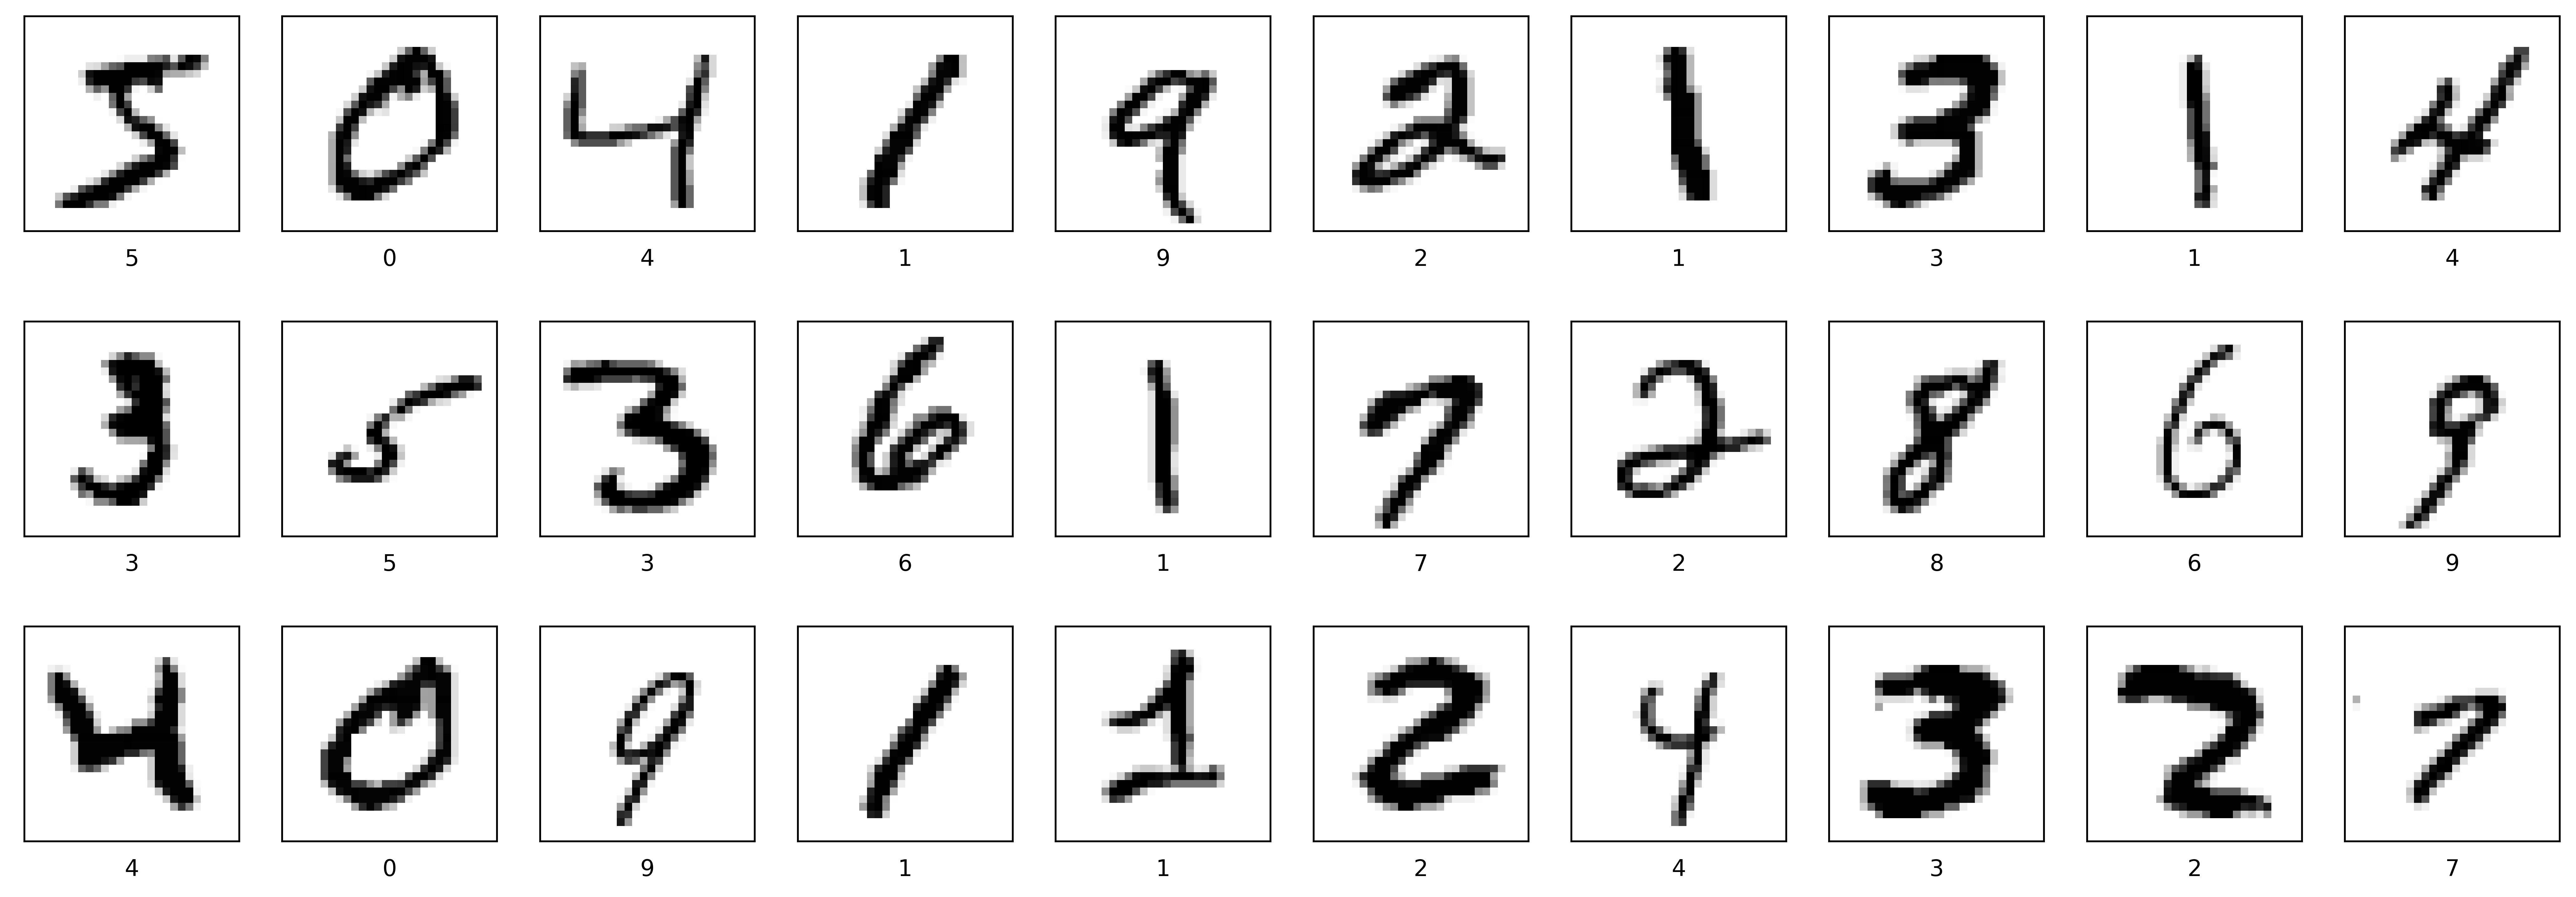

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# setting a random seed to reproduce results
seed=4
tf.random.set_seed(4)

import cv2 as cv
import os

### Loading Handwritten Digit Image 

In [2]:
mnist = tf.keras.datasets.mnist

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [3]:
(X_train.shape, Y_train.shape), (X_test.shape, Y_test.shape)

(((60000, 28, 28), (60000,)), ((10000, 28, 28), (10000,)))

In [4]:
pd.DataFrame(Y_train).value_counts()

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
dtype: int64

## Data Preprocessing
#### Check the first digit

#### Plot the first digit

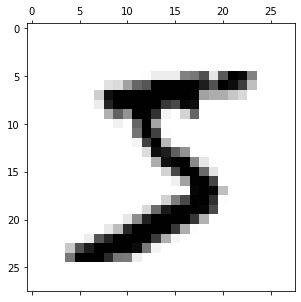

In [5]:
plt.matshow(X_train[0],  cmap=plt.cm.binary)

In [6]:
# Check the actual digit value
Y_train[0] 

5

### Plot the first 50 digit with their actual label

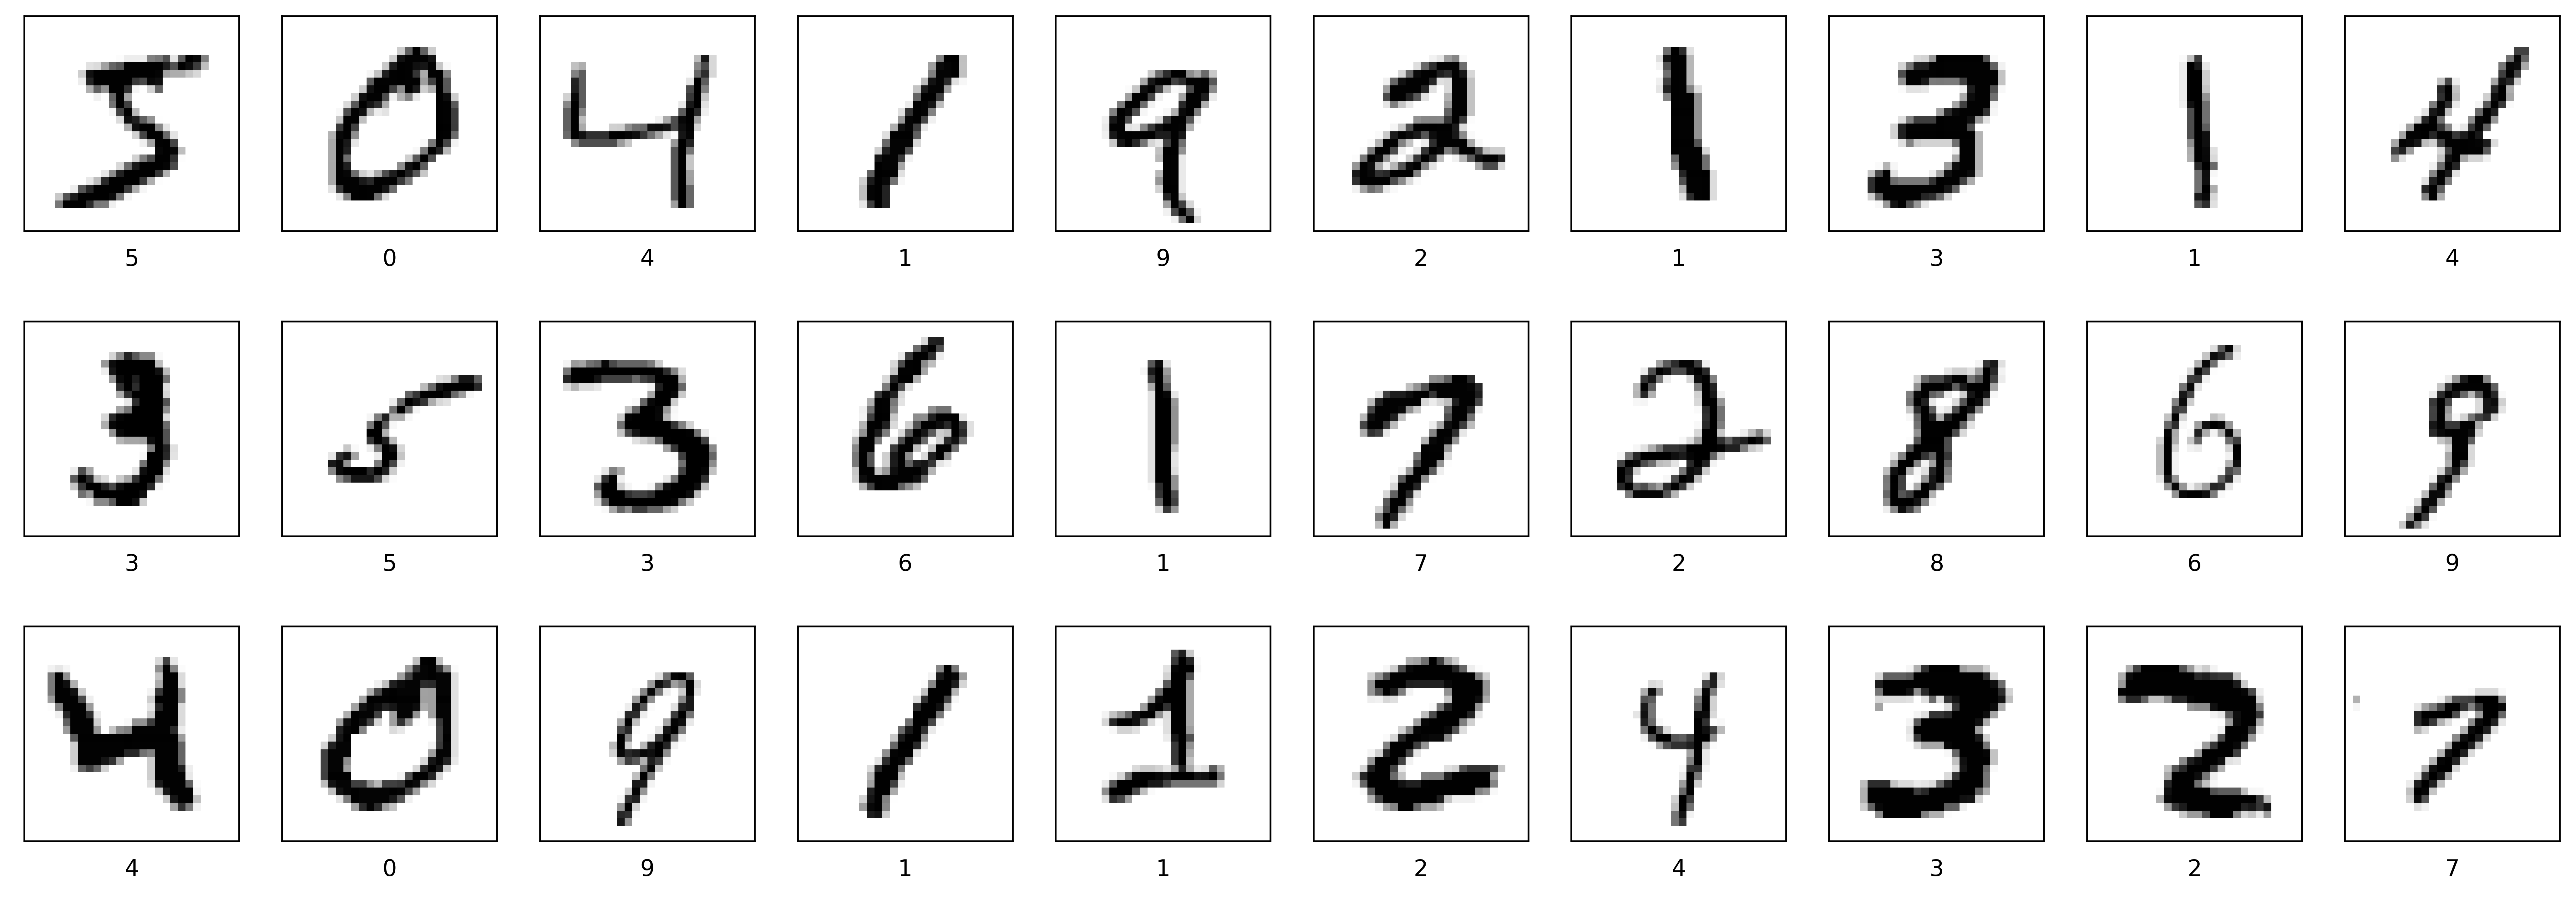

In [7]:
plt.figure(figsize=(20,7), dpi = 523)
for i in range(30):
    plt.subplot(3,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(Y_train[i])                      # Adding label as the value of handwritten digit
plt.show()

### Split train and validation set

In [8]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train,
                                                  test_size=0.2, 
                                                  random_state=2,
                                                  shuffle=True, 
                                                  stratify=Y_train) 
pd.DataFrame(y_train).value_counts()

1    5394
7    5012
3    4905
2    4766
9    4759
0    4738
6    4734
8    4681
4    4674
5    4337
dtype: int64

In [9]:
print('Train Data shape :',x_train.shape)
print('Train Data shape :',x_val.shape)
print('Train Data shape :',X_test.shape)

Train Data shape : (48000, 28, 28)
Train Data shape : (12000, 28, 28)
Train Data shape : (10000, 28, 28)


### Add a channels dimension

In [10]:
x_train = x_train.reshape(-1,28,28,1)
x_val = x_val.reshape(-1,28,28,1)
x_test = X_test.reshape(-1,28,28,1)

### Scalling the value for better accuracy

In [11]:
x_train, x_val, x_test = x_train / 255, x_val / 255, x_test / 255

In [12]:
# One hot-encoding the labels
y_train = tf.keras.utils.to_categorical(y_train)
y_valid = tf.keras.utils.to_categorical(y_val)

y_test = tf.keras.utils.to_categorical(Y_test)

<h2 style="color:#00008B">Model Building for image classification</h2>

In [13]:
# defining batch size, number epochs (iterations) and the steps in each epoch

batch = 96
epochs = 20

steps_per_epoch = x_train.shape[0]//batch
steps_per_epoch

500

In [14]:
"""
simple data augmentation through data generation, which rotates an input image randomly 
betweeen an angle of 0 to 10. 
Same for the zoom range in ratio of 0.1.

"""
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
                             zoom_range=0.1
                            )

In [15]:
# setting data generator to be ready for model

image_generator = datagen.flow(x_train, y_train, 
                               batch_size=batch, 
                               seed=seed,
                              )

<h3 style="color:green">Build simple artificial neural network for image classification</h3>

In [16]:
print('The Unique digits are :', sorted(pd.unique(Y_train)))
n = len(pd.unique(Y_train))
print('There are total',n, 'unique digits')

The Unique digits are : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
There are total 10 unique digits


<h2 style="color:Green">Convolutional neural network</h2>

In [17]:
# Model Bulding
# Model Bulding
cnn = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape = (28,28,1)),         # Convolution Layer
    layers.Conv2D(32, (4, 4), activation = 'relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(filters=64, kernel_size=(2, 2), activation='relu'),         # Convolution Layer
    layers.Conv2D(64, (4, 4), activation = 'relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),                                             # MaxPooling
    
    layers.Conv2D(128, (3, 3), activation = 'relu'),
    layers.BatchNormalization(),
    
    layers.Flatten(),                        
    layers.Dense(150, activation = tf.nn.relu),     # Hidden layer
    layers.Dense(150, activation = tf.nn.relu),      # Hidden layer
    layers.Dense(n, activation = tf.nn.softmax)     # Output layer
])

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        16416     
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        8256      
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          6

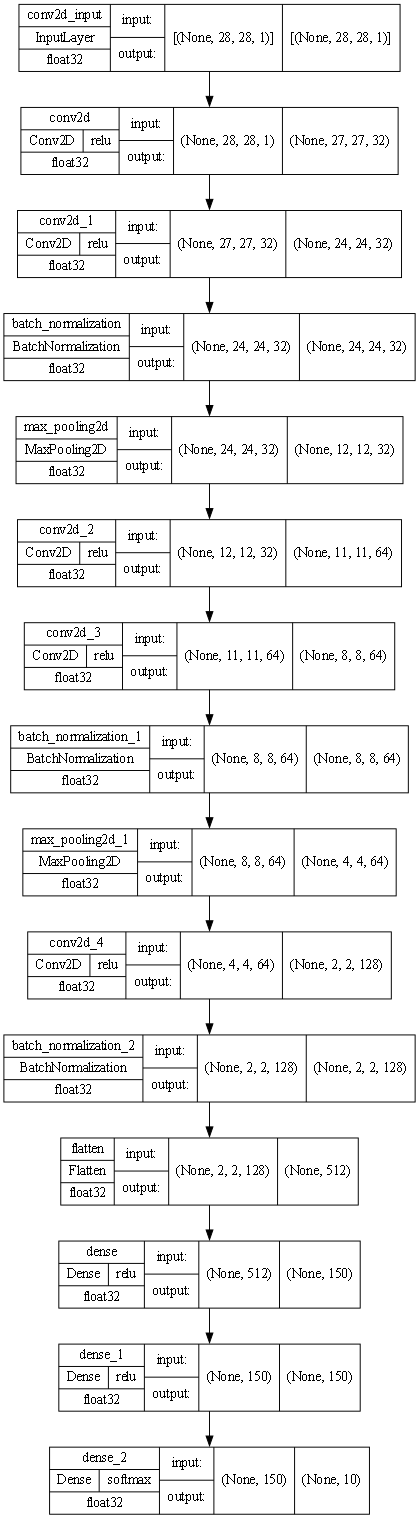

In [18]:
plot_model(cnn, 
           to_file='Handwritten_Digits_Recognization.png',
           show_shapes = True, 
           show_dtype=True,
           show_layer_names = True, 
           rankdir = 'TB',#'LR',
           expand_nested=True,
           dpi = 70,
           show_layer_activations = True)

In [19]:
# Some parameters to control the training process, avoid overfitting, saving the best model in training, etc.

lr_rate = 0.0003

#Stop training when a monitored metric has stopped improving.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                  patience = 3,
                                                  min_delta = 1e-4,
                                                  restore_best_weights = True)
# save the Keras model or model weights
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = 'saved_model/best_model_todate', 
                                                 save_best_only = True, 
                                                 save_weights_only = True,
                                                 monitor='val_accuracy',
                                                 mode='max')

# terminates training when a NaN loss is encountered
tn = tf.keras.callbacks.TerminateOnNaN()

'''
A LearningRateSchedule that uses an exponential decay schedule.

When training a model, it is often useful to lower the learning rate as
the training progresses. This schedule applies an exponential decay function
to an optimizer step, given a provided initial learning rate.
'''
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = lr_rate,
                                                           decay_steps = steps_per_epoch//4,
                                                           decay_rate= 0.80,
                                                           staircase=True)
# Learning rate scheduler
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Reduce learning rate when a metric has stopped improving
lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                  factor = 0.1,
                                                  patience = 4, 
                                                  verbose = 3)

### Choose an optimizer and loss function for training

In [20]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_rate)

In [21]:
# Compile the model
cnn.compile(optimizer = optimizer ,
              loss = loss_object,
              metrics=['accuracy'])

history = cnn.fit(image_generator, 
                    epochs=epochs, 
                    validation_data=(x_val, y_valid), 
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [lr_scheduler, lr_plateau, checkpoint_callback, early_stopping, tn]
                   )

Epoch 1/20
500/500 [==============================] - 86s 171ms/step - loss: 0.1662 - accuracy: 0.9506 - val_loss: 0.1068 - val_accuracy: 0.9734 - lr: 3.0000e-04
Epoch 2/20
500/500 [==============================] - 88s 177ms/step - loss: 0.0480 - accuracy: 0.9852 - val_loss: 0.0499 - val_accuracy: 0.9839 - lr: 3.0000e-04
Epoch 3/20
500/500 [==============================] - 98s 196ms/step - loss: 0.0359 - accuracy: 0.9891 - val_loss: 0.0327 - val_accuracy: 0.9901 - lr: 3.0000e-04
Epoch 4/20
500/500 [==============================] - 103s 206ms/step - loss: 0.0278 - accuracy: 0.9915 - val_loss: 0.0869 - val_accuracy: 0.9726 - lr: 3.0000e-04
Epoch 5/20
500/500 [==============================] - 97s 194ms/step - loss: 0.0235 - accuracy: 0.9926 - val_loss: 0.0279 - val_accuracy: 0.9911 - lr: 3.0000e-04
Epoch 6/20
500/500 [==============================] - 119s 237ms/step - loss: 0.0217 - accuracy: 0.9930 - val_loss: 0.0260 - val_accuracy: 0.9925 - lr: 3.0000e-04
Epoch 7/20
500/500 [======

### Model Evaluation

In [22]:
loss, accuracy = cnn.evaluate(x_test, y_test)
print('The accuracy of model on unknown data is',round((accuracy*100),2),'%')

313/313 [==============================] - 5s 16ms/step - loss: 0.0252 - accuracy: 0.9930
The accuracy of model on unknown data is 99.3 %


In [23]:
history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']                        # Accuracy obtained on training data
val_acc = history_dict['val_accuracy']                # Accuracy obtained on Validation data

loss = history_dict['loss']                                  # Losses obtained on training data
val_loss = history_dict['val_loss']                          # Losses obtained on validation data

### Training and validation loss

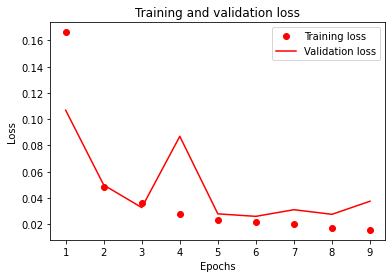

In [24]:
epochs = range(1, len(acc) + 1)                              # Epoch = range(1, 10+1)  10 iterations        

# Training Loss
plt.plot(epochs, loss, 'ro', label='Training loss')          # "ro" is for "red dot"
# Validation Loss
plt.plot(epochs, val_loss, 'r', label='Validation loss')     # r is for "solid red line"

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Training and validation accuracy

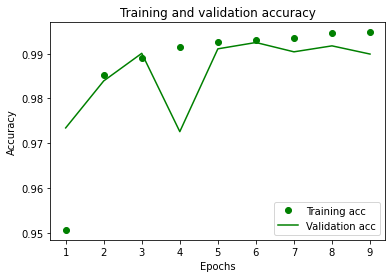

In [25]:
# Training accuracy
plt.plot(epochs, acc, 'go', label='Training acc')                 # "go" is for "green dot"
# Validation accuracy
plt.plot(epochs, val_acc, 'g', label='Validation acc')            # g is for "solid green line"
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

### Prediction

In [26]:
# Predict the label
y_predicted = cnn.predict(x_test)

# Get the maximum value integer as the output for the predicted value 
y_predicted_labels = [np.argmax(element) for element in y_predicted]

print('Predicted Label :',y_predicted_labels[:10])
print('Actual Label    :',Y_test[:10])

Predicted Label : [7, 2, 1, 0, 4, 1, 4, 9, 5, 9]
Actual Label    : [7 2 1 0 4 1 4 9 5 9]


### Confusion matrix¶

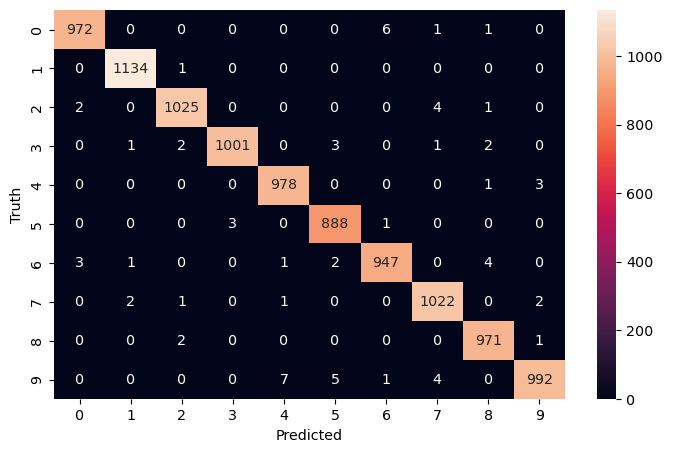

In [27]:
cm = tf.math.confusion_matrix(labels=Y_test, predictions=y_predicted_labels)

plt.figure(figsize = (8,5), dpi = 103)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [28]:
print("Classification Report: \n", classification_report(Y_test, y_predicted_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       1.00      0.99      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      1.00      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      1.00      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



## Verify predictions

In [29]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel("Pred: {} ({:2.0f}%) \n Truth : {}".format(predicted_label, (100*np.max(predictions_array)),
                                                          true_label), color=color)
    
def plot_value_array(i, predictions_array, true_labels):
    true_label = true_labels[i]
    plt.grid(False)
    plt.xticks(range(10))

    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

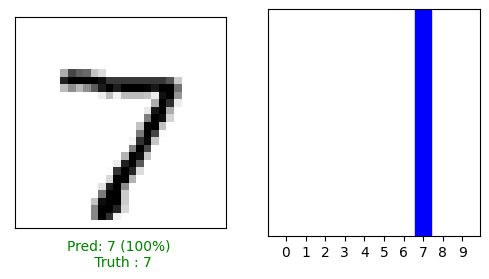

In [30]:
i = 0
plt.figure(figsize=(6,3), dpi = 100)
plt.subplot(1,2,1)
plot_image(i, y_predicted[i], Y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, y_predicted[i], Y_test)
plt.show()

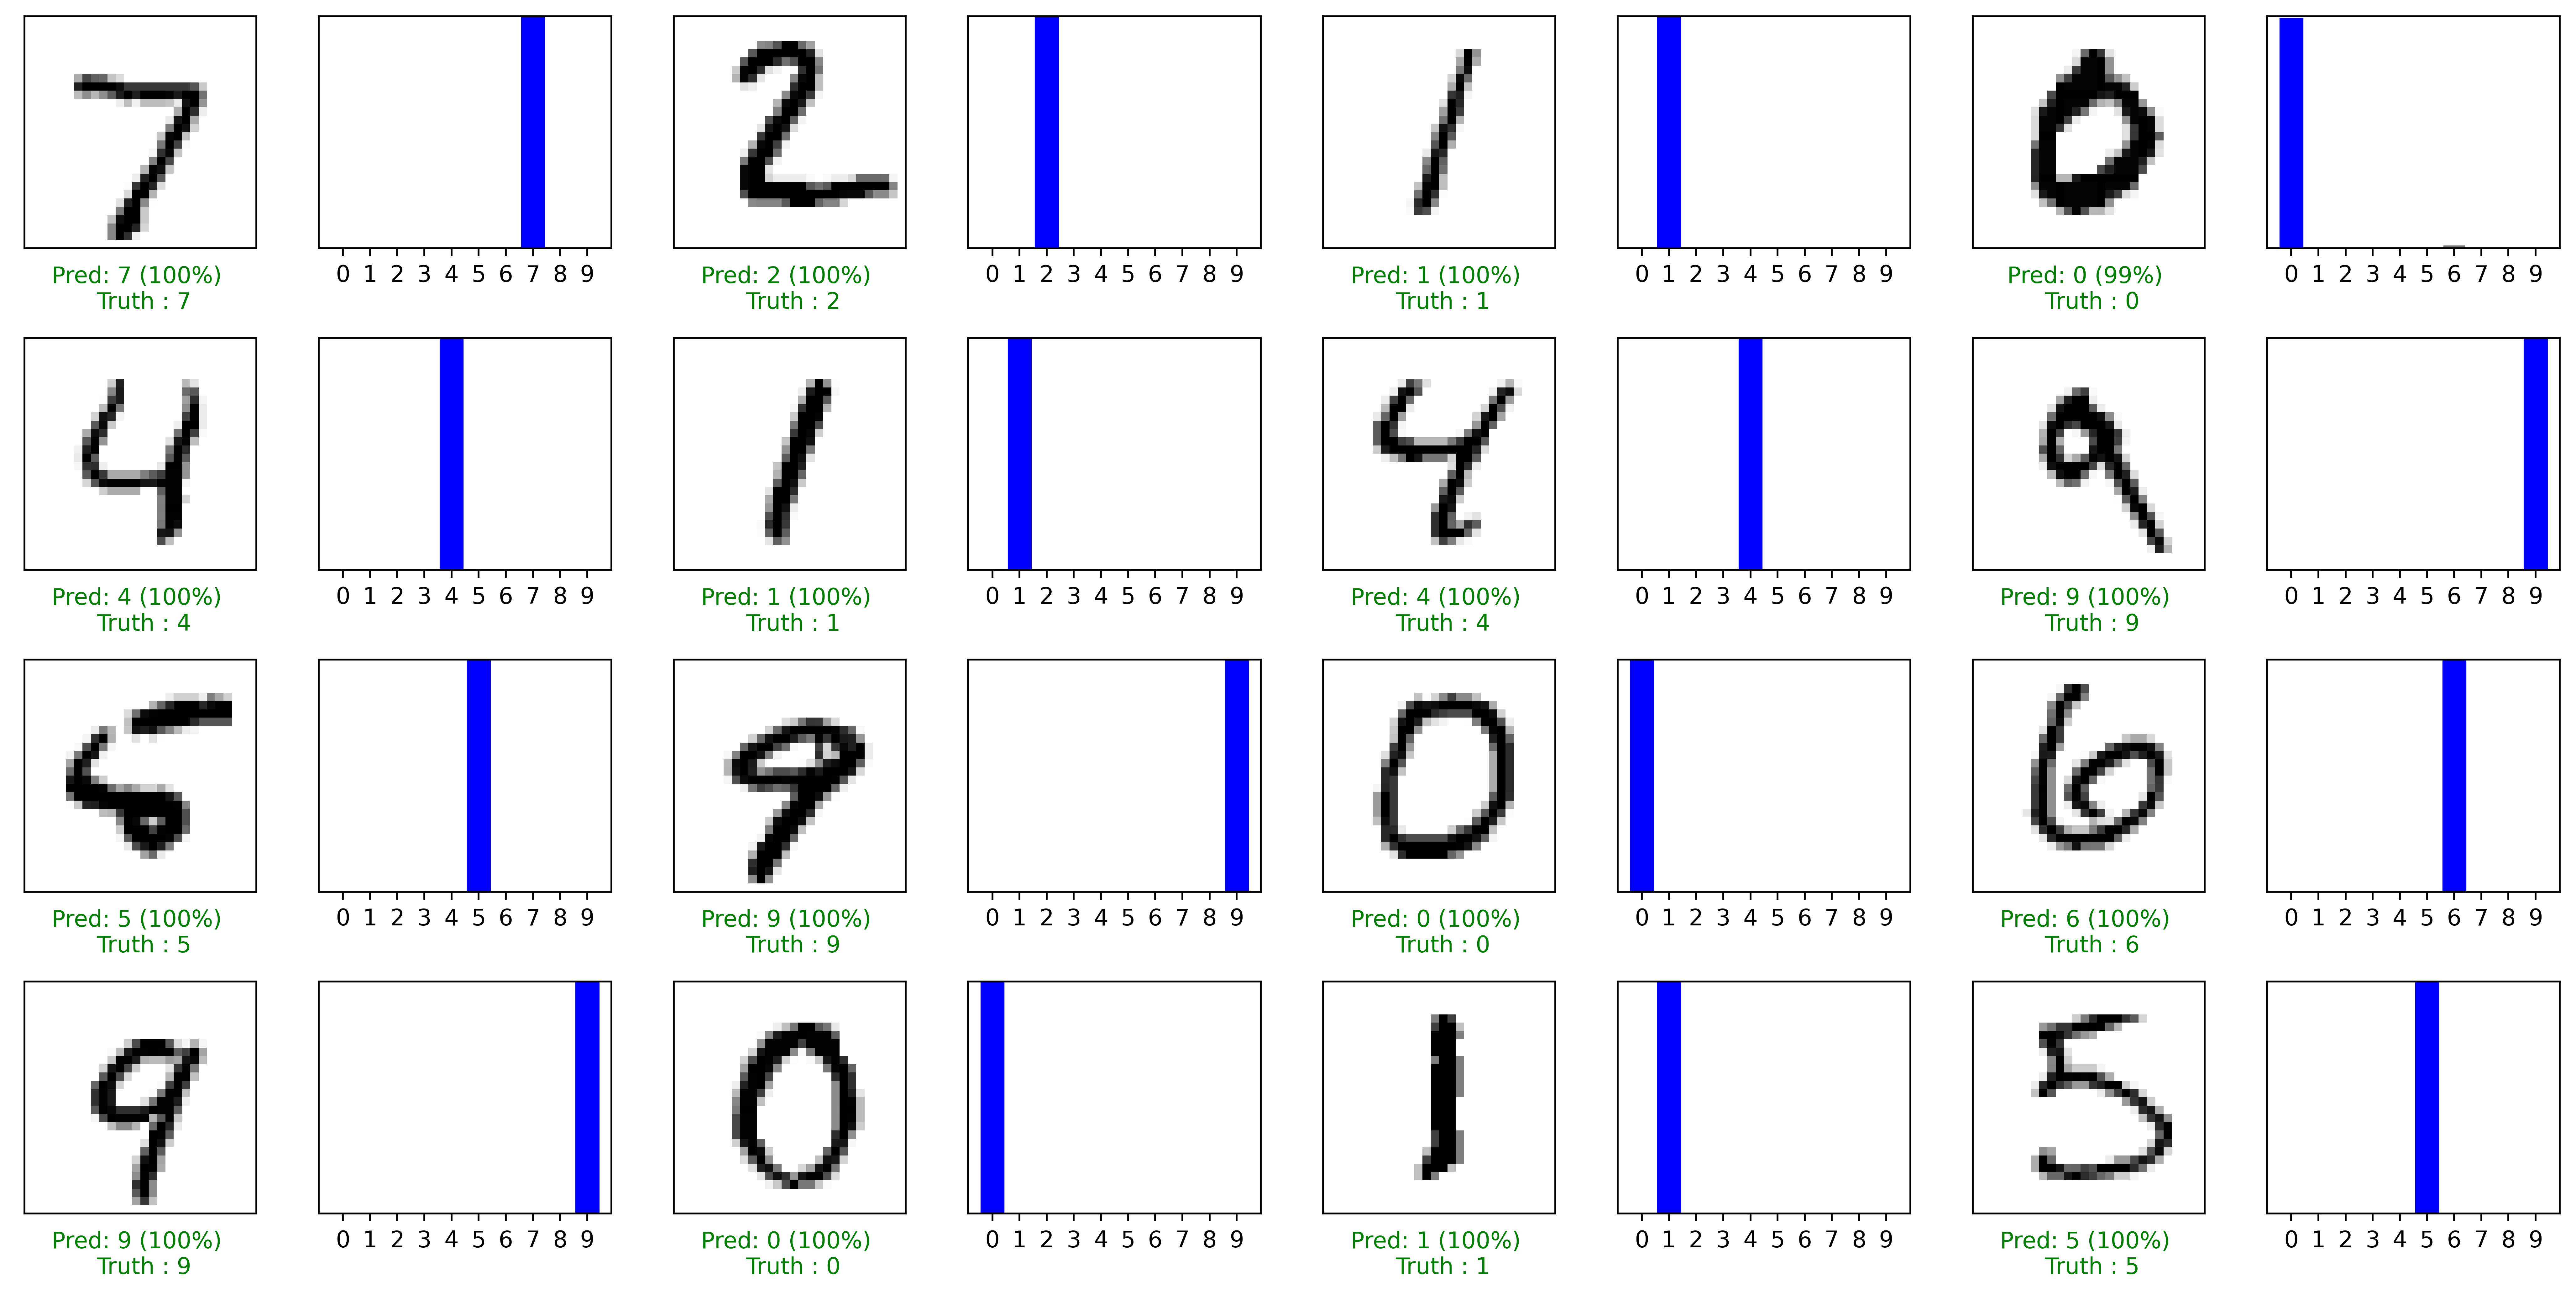

In [31]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 4
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows), dpi = 523)
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, y_predicted[i], Y_test, x_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, y_predicted[i], Y_test)
plt.tight_layout()
plt.show()

### Check the wrong predictions

In [32]:
#predicted_label = np.argmax(predictions_array)
count = 0
wrong_predictions = []
for i in range(len(Y_test)):
    predicted_label = np.argmax(y_predicted[i])
    if predicted_label != Y_test[i]:
        count +=1
        wrong_predictions.append(i)
print('There are',count,'wrong predictions in test datasets')
print('Wrong predicted indices :\n',wrong_predictions)

There are 70 wrong predictions in test datasets
Wrong predicted indices :
 [359, 445, 447, 449, 582, 625, 659, 726, 947, 1014, 1209, 1232, 1242, 1247, 1260, 1414, 1522, 1570, 1621, 1709, 1901, 2018, 2035, 2098, 2130, 2135, 2293, 2318, 2417, 2462, 2597, 2654, 2659, 2720, 2927, 2939, 2953, 3218, 3225, 3266, 3422, 3762, 4176, 4284, 4443, 4620, 4681, 4740, 4823, 4838, 5734, 5937, 5955, 6569, 6571, 6576, 6597, 6625, 6651, 7216, 8094, 8277, 9009, 9620, 9638, 9642, 9664, 9692, 9729, 9839]


Predicted Label : 7
Actual Label    : 2


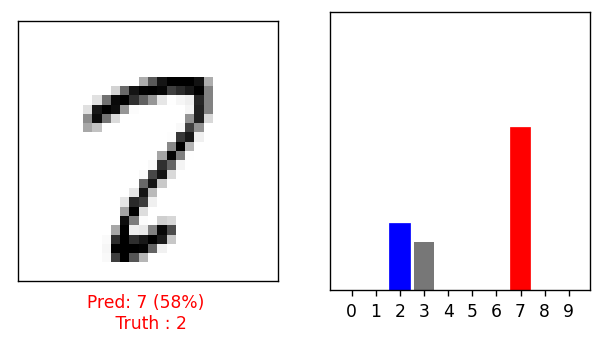

In [33]:
print('Predicted Label :',np.argmax(y_predicted[wrong_predictions[-1]]))
print('Actual Label    :',Y_test[wrong_predictions[-1]])
i = wrong_predictions[-1]
plt.figure(figsize=(6,3), dpi = 123)
plt.subplot(1,2,1)
plot_image(i, y_predicted[i], Y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, y_predicted[i], Y_test)
plt.show()

In [34]:
num_rows = 4
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows), dpi = 723)

for ix in range(num_images):
    i = wrong_predictions[ix]

    plt.subplot(num_rows, 2*num_cols, 2*ix+1)
    plot_image(i, y_predicted[i], Y_test, x_test)
    plt.subplot(num_rows, 2*num_cols, 2*ix+2)
    plot_value_array(i, y_predicted[i], Y_test)
plt.tight_layout()
plt.show()

### Save the  Model

In [35]:
!mkdir  saved_model
cnn.save('saved_model/my_model')

A subdirectory or file saved_model already exists.


INFO:tensorflow:Assets written to: saved_model/my_model\assets


###  Load the model

In [36]:
model = tf.keras.models.load_model('saved_model/my_model')

# Use the trained model

### Image Processing

In [37]:
def preprocess_image(image_path):
    img = cv.imread(image_path)                              # Read the image file
    img = cv.cvtColor(img, cv.COLOR_RGB2BGR)                 # Go to original color space

    plt.figure(figsize=(15, 5), dpi = 100)
    
    plt.subplot(1, 4, 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)                                           # Plot the original image
    plt.xlabel('Original\n Shape: {}'.format(img.shape))      # Shape of original image
    
    img = cv.cvtColor(img, cv.COLOR_BGR2HSV)                 # color space space to hsv
    
    img = cv.resize(img, (28,28))                             # Reshape to 28 X 28 pixel
    img = img/255.0                                           # Scale the image between (0,1)


    # Image in RBG space
    h = img[ : , : , 0 ]      # - Hue 
    s = img[ : , : , 1 ]      # - Saturation
    v = img[ : , : , 2 ]      # - Value
    
    
    # Red
    plt.subplot(1, 4, 2)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(h, cmap= plt.cm.binary)                 # Plot the original image
    plt.xlabel('Hue\n Shape: {}'.format(h.shape))      # Shape of original image
    
    plt.subplot(1, 4, 3)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(s, cmap= plt.cm.binary)                   # Plot the green color space image
    plt.xlabel('Satuartion\n Shape :{}'.format(s.shape))      # Shape of green color space image

    plt.subplot(1, 4, 4)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(v, cmap= plt.cm.binary)                  # Plot the blue color space image
    plt.xlabel('Value\n Shape: {}'.format(v.shape))      # Shape of blue space image
    plt.show()

    return v

In [38]:
def pred_label(path):
    img = preprocess_image(path)
    #print(img.shape)

    # Add the image to a batch where it's the only member.
    img = (np.expand_dims(img,0))
    img = (np.expand_dims(img,3))

    print(img.shape)


    # Predict the correct label for this image
    pred = model.predict(img)

    print('\nLabel         :',np.argmax(pred))
    print('Predicted Label :',np.argmax(pred))

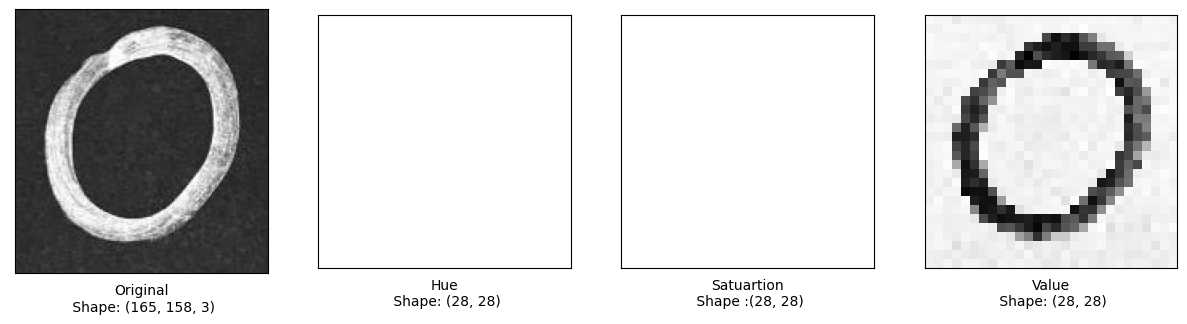

(1, 28, 28, 1)

Label         : 0
Predicted Label : 0


In [39]:
path = 'digit_image/0.jpg'
pred_label(path)

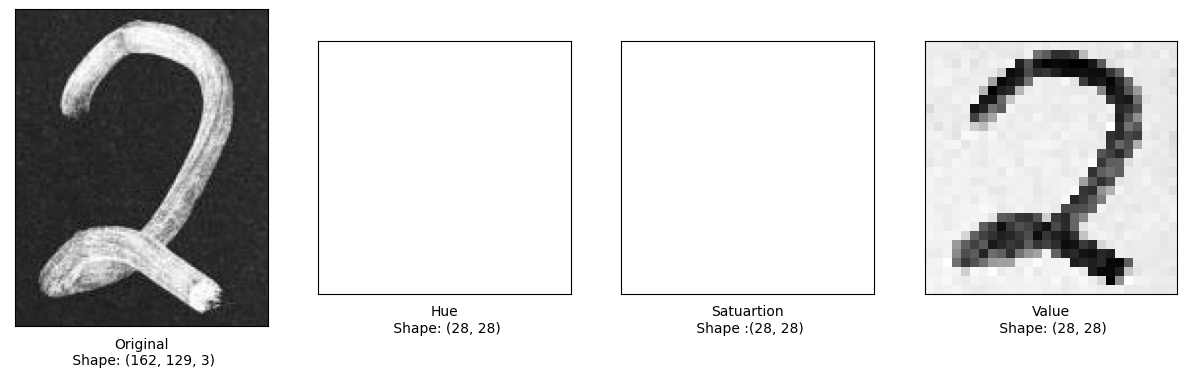

(1, 28, 28, 1)

Label         : 2
Predicted Label : 2


In [40]:
path = 'digit_image/2_.jpg'
pred_label(path)

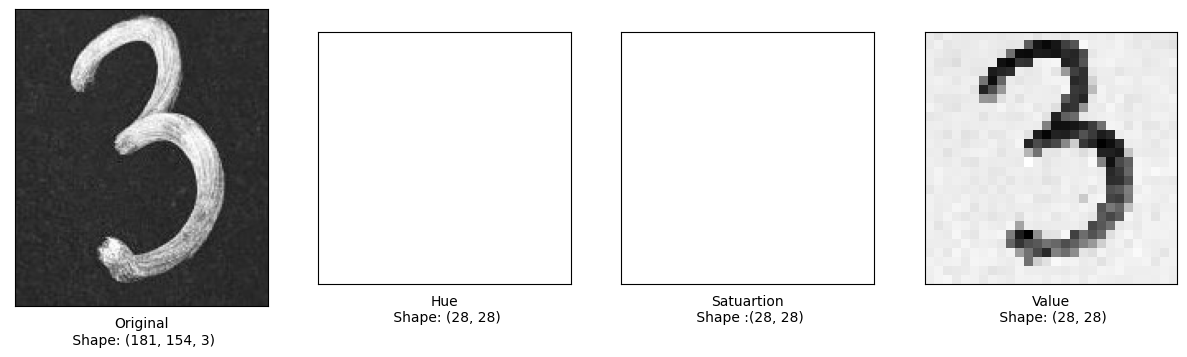

(1, 28, 28, 1)

Label         : 3
Predicted Label : 3


In [41]:
path = 'digit_image/3.jpg'
pred_label(path)

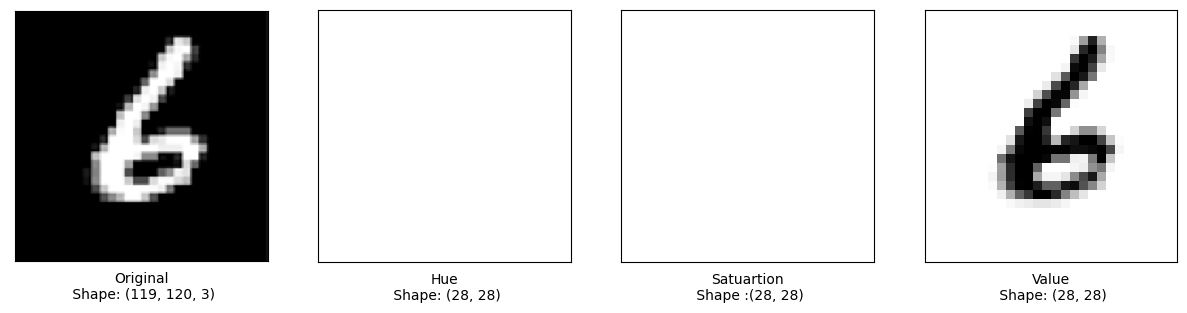

(1, 28, 28, 1)

Label         : 6
Predicted Label : 6


In [42]:
path = 'digit_image/6.png'
pred_label(path)

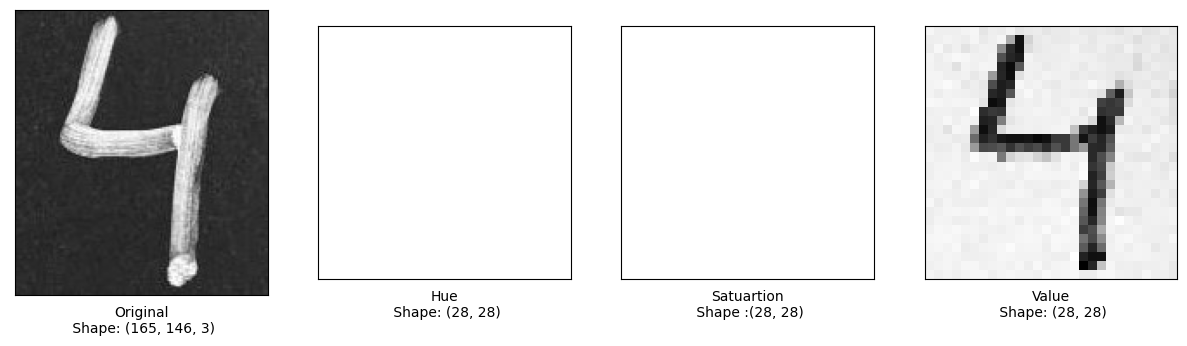

(1, 28, 28, 1)

Label         : 4
Predicted Label : 4


In [43]:
path = 'digit_image/4.jpg'
pred_label(path)

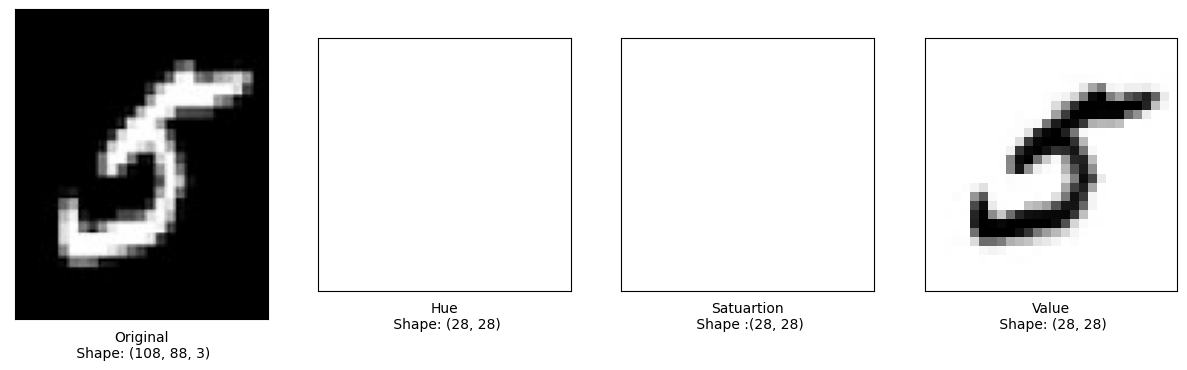

(1, 28, 28, 1)

Label         : 5
Predicted Label : 5


In [44]:
path = 'digit_image/5_.jpg'
pred_label(path)

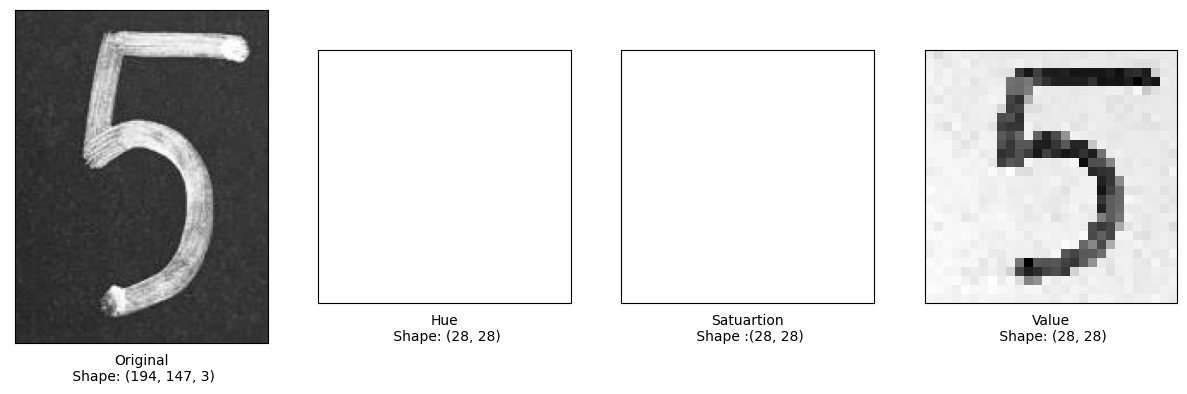

(1, 28, 28, 1)

Label         : 5
Predicted Label : 5


In [45]:
path = 'digit_image/5.jpg'
pred_label(path)

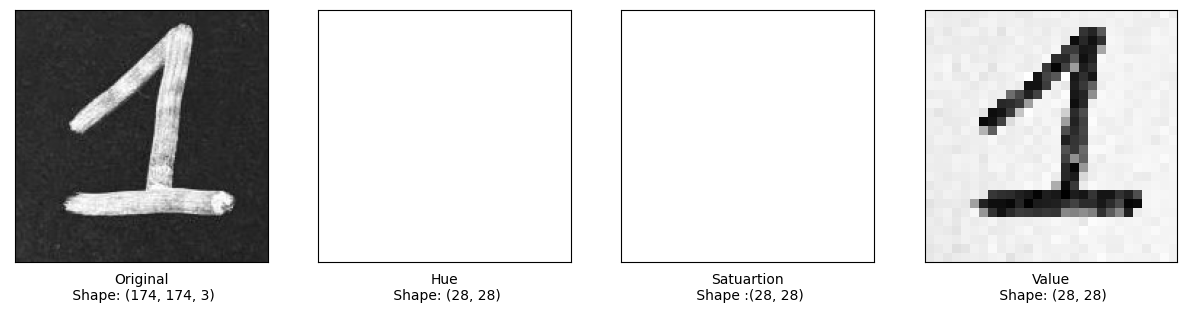

(1, 28, 28, 1)

Label         : 2
Predicted Label : 2


In [46]:
path = 'digit_image/1.jpg'
pred_label(path)

### Wrong predicted

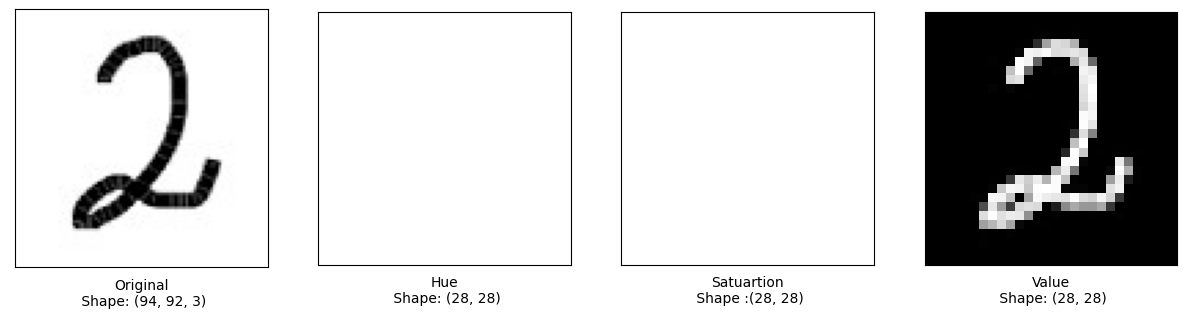

(1, 28, 28, 1)

Label         : 4
Predicted Label : 4


In [47]:
path = 'digit_image/2.jpg'
pred_label(path)

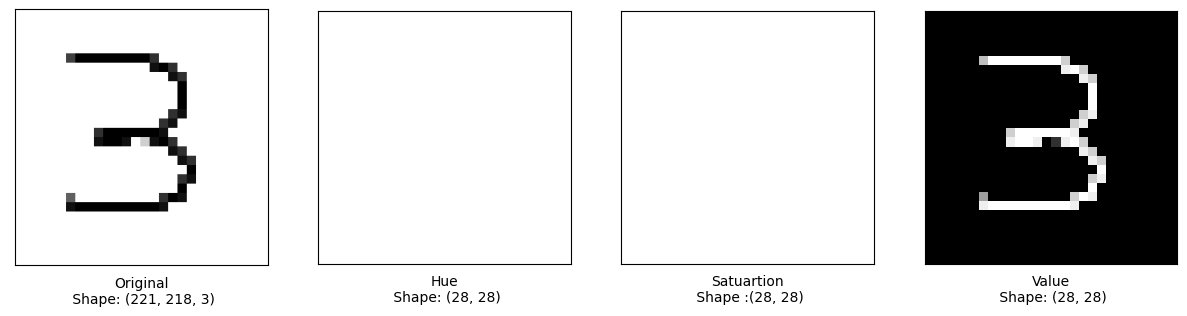

(1, 28, 28, 1)

Label         : 2
Predicted Label : 2


In [48]:
path = 'digit_image/3.png'
pred_label(path)

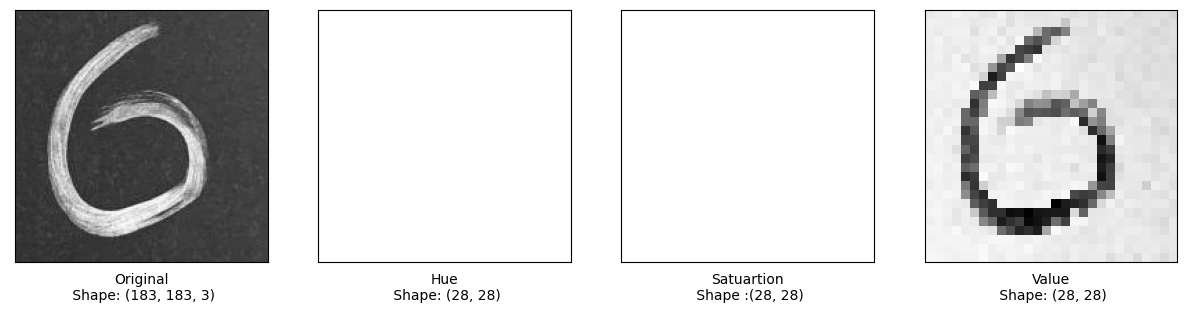

(1, 28, 28, 1)

Label         : 8
Predicted Label : 8


In [49]:
path = 'digit_image/6.jpg'
pred_label(path)

<h2 style='color:green', align = 'center' >Final Accuracy optained = 99.19 %</h2>